# Sampling π with MCMC

In [1]:
import logging
import numpy as np
import plotly.plotly
from plotly import tools
import plotly.offline as py
from plotly.graph_objs import *
import concurrent.futures as futures
from scipy.optimize import minimize_scalar

py.init_notebook_mode(connected=True)

In [8]:
class MarkovChain(object):
    """Samples points using a Markov chain."""
    def __init__(self, num_steps, step_size):
        self.num_steps = num_steps
        self.step_size = step_size
        self.acceptance_ratio = None
        self.x = np.empty((self.num_steps, 2))

    def reset(self):
        self.acceptance_ratio = None
        self.x = np.empty((self.num_steps, 2))

    def run(self, initial_pos=[0., 0.]):
        accept_count = 0

        # Initial position
        self.x[0] = initial_pos

        for i in range(self.num_steps - 1):
            self.x[i+1], accepted = self._move(self.x[i]) 
            accept_count += int(accepted)


        self.acceptance_ratio = accept_count / self.num_steps

        return self.x


    def _move(self, current_position):
        step = self._generate_step()
        proposed_position = current_position + step

        if abs(proposed_position[0]) <= 1 and abs(proposed_position[1]) <= 1:
            return proposed_position, True
        else:
            return current_position, False

    def _generate_step(self):
        return np.random.uniform(-self.step_size, self.step_size, 2)

    def samples(self):
        return (np.sum(self.x**2, axis=1) <= 1)*4

    def pi_estimate(self):
        return np.mean(self.samples())

    def plot(self, title):
        lyt = Layout(
            title = title,
            yaxis = dict(scaleanchor="x", domain=[-1,1]),
            yaxis2 = dict(scaleanchor="x2", domain=[-1,1]),
            yaxis3 = dict(scaleanchor="x3", domain=[-1,1]),
            shapes = [{'type': 'circle', 'x0': -1, 'y0': -1, 'x1': 1, 'y1': 1, 'xref':'x', 'yref':'y'},
                      {'type': 'circle', 'x0': -1, 'y0': -1, 'x1': 1, 'y1': 1, 'xref':'x2', 'yref':'y2'},
                      {'type': 'circle', 'x0': -1, 'y0': -1, 'x1': 1, 'y1': 1, 'xref':'x3', 'yref':'y3'}])

        fig = tools.make_subplots(rows=1, cols=3)

        for i, num_steps in enumerate([1000, 4000, 20000]):
            trace = Scatter(x=self.x[:num_steps, 0],
                            y=self.x[:num_steps, 1],
                            mode='lines+markers',
                            name=num_steps)

            fig.append_trace(trace, 1, i+1)
        
        fig['layout'].update(lyt)
        
        # Plot to a static image, performs better since we have too many data points.
        plotly.plotly.image.ishow(fig, width=1000, scale=2)

Let’s plot the Markov chain for different number of steps using a small step size (0.1).

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



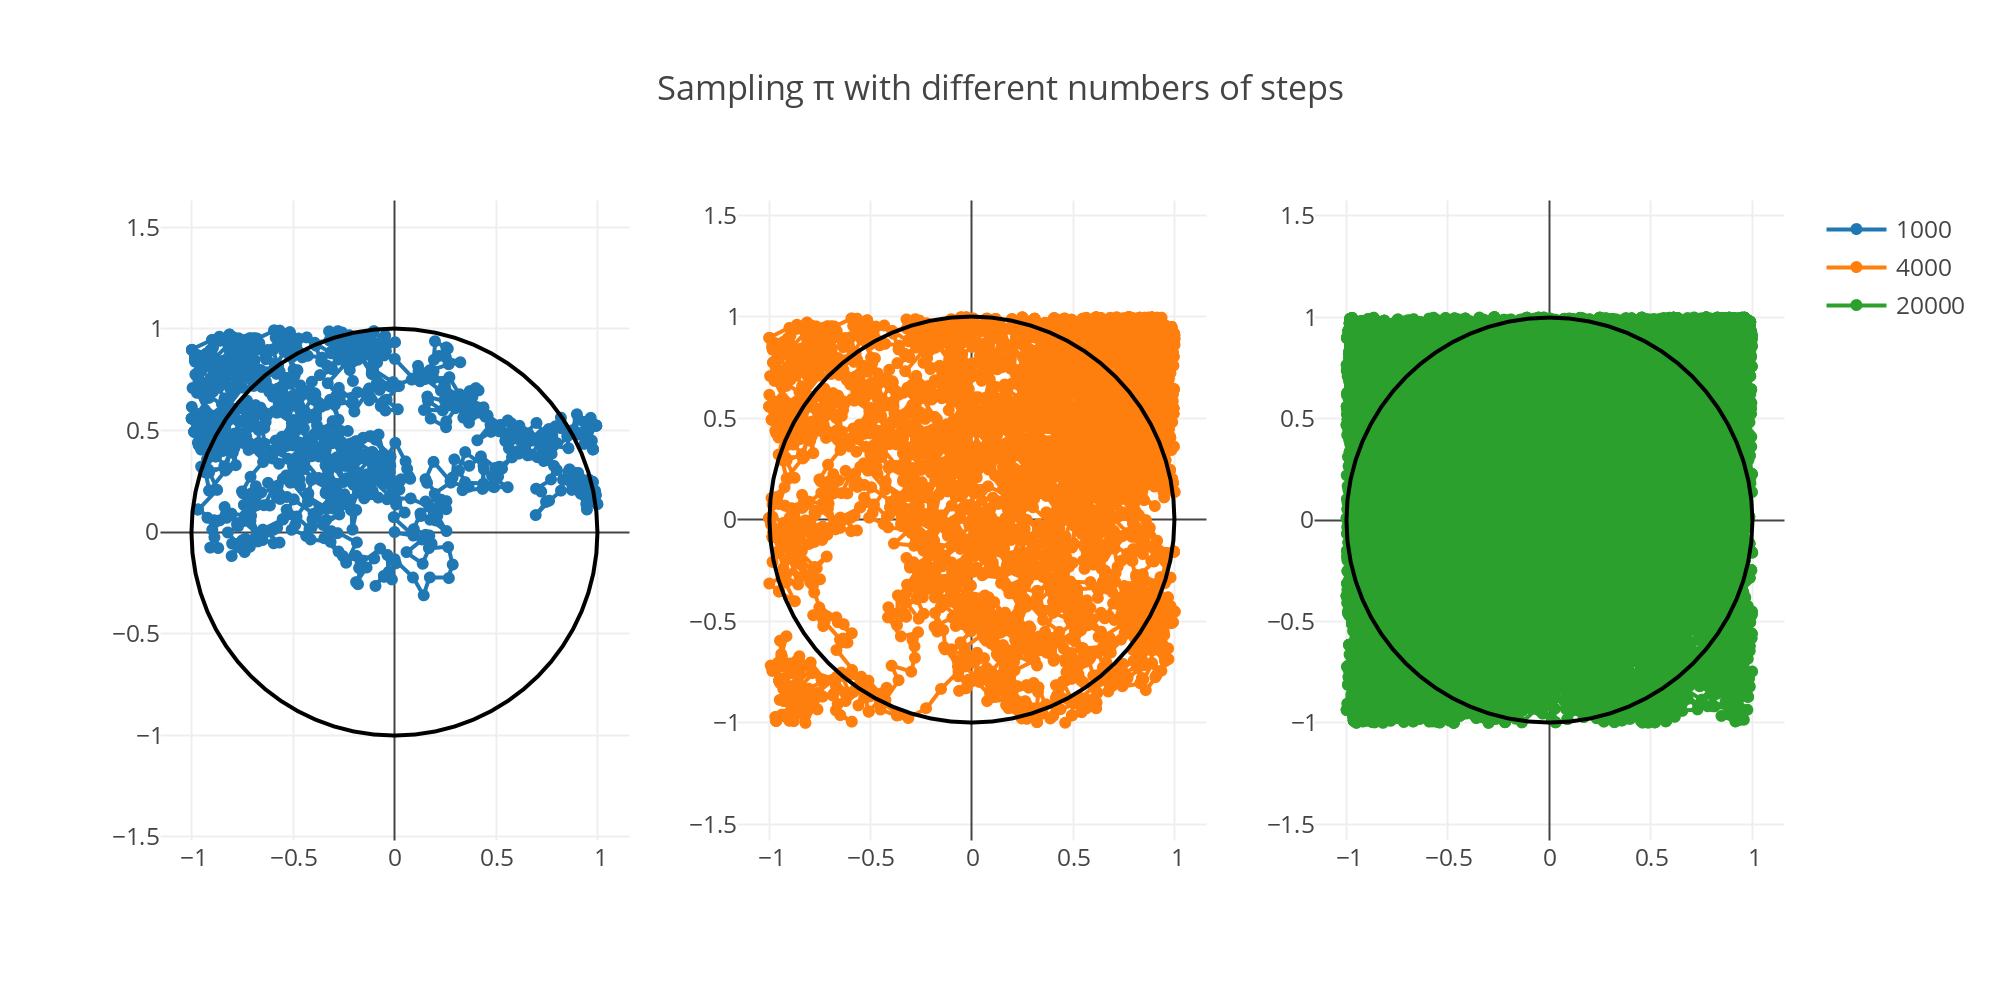

Acceptance ratio: 0.950850


In [11]:
mc = MarkovChain(20000, step_size=0.1)
mc.run()
mc.plot("Sampling π with different numbers of steps")
print("Acceptance ratio: {:f}".format(mc.acceptance_ratio))

# Step size

From one hand we want to have bigger step size to allow the chain to visit all the square in a smaller number of steps, from the other hand if this value is too big the acceptance would be very small. 
In this case the acceptance is very high, since the proposed move could be rejected only in a small region near to the frontier of the square. Unfortunately we can also see that the chain covers uniformly the whole area only after a big number of steps (in this case the cover is almost uniform after 20000 steps), therefore this step size is not very good.

Let’s try to optimize the step size to get an acceptance ratio of about 0.5. Of course in every realization this will be
sligtly different so that our estimation will not be very precise (since this is a rule of tumb it is ok).

In [4]:
def optimize_acceptance_ratio(step_size, desired_ratio=0.5):
    """Returns the absolute difference between the acceptance ratio and the desired one given the step size."""
    m = MarkovChain(100000, step_size)
    m.run()

    return abs(m.accept_ratio - desired_ratio)

optimized = minimize_scalar(optimize_acceptance_ratio, bounds=(0.1, 10), tol=1e-2, options=dict(maxiter=100))

if not optimized.success:
    # Convergence is not guaranteed since the function is not deterministic.
    logging.warn("Optimization did non converge! Use the result at your own risk.")

optimal_step_size = optimized.x

print("Optimal step size: {:f}".format(optimal_step_size))

Optimal step size: 1.170444


Let’s do a new Markov chain with the "optimal" step size.

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



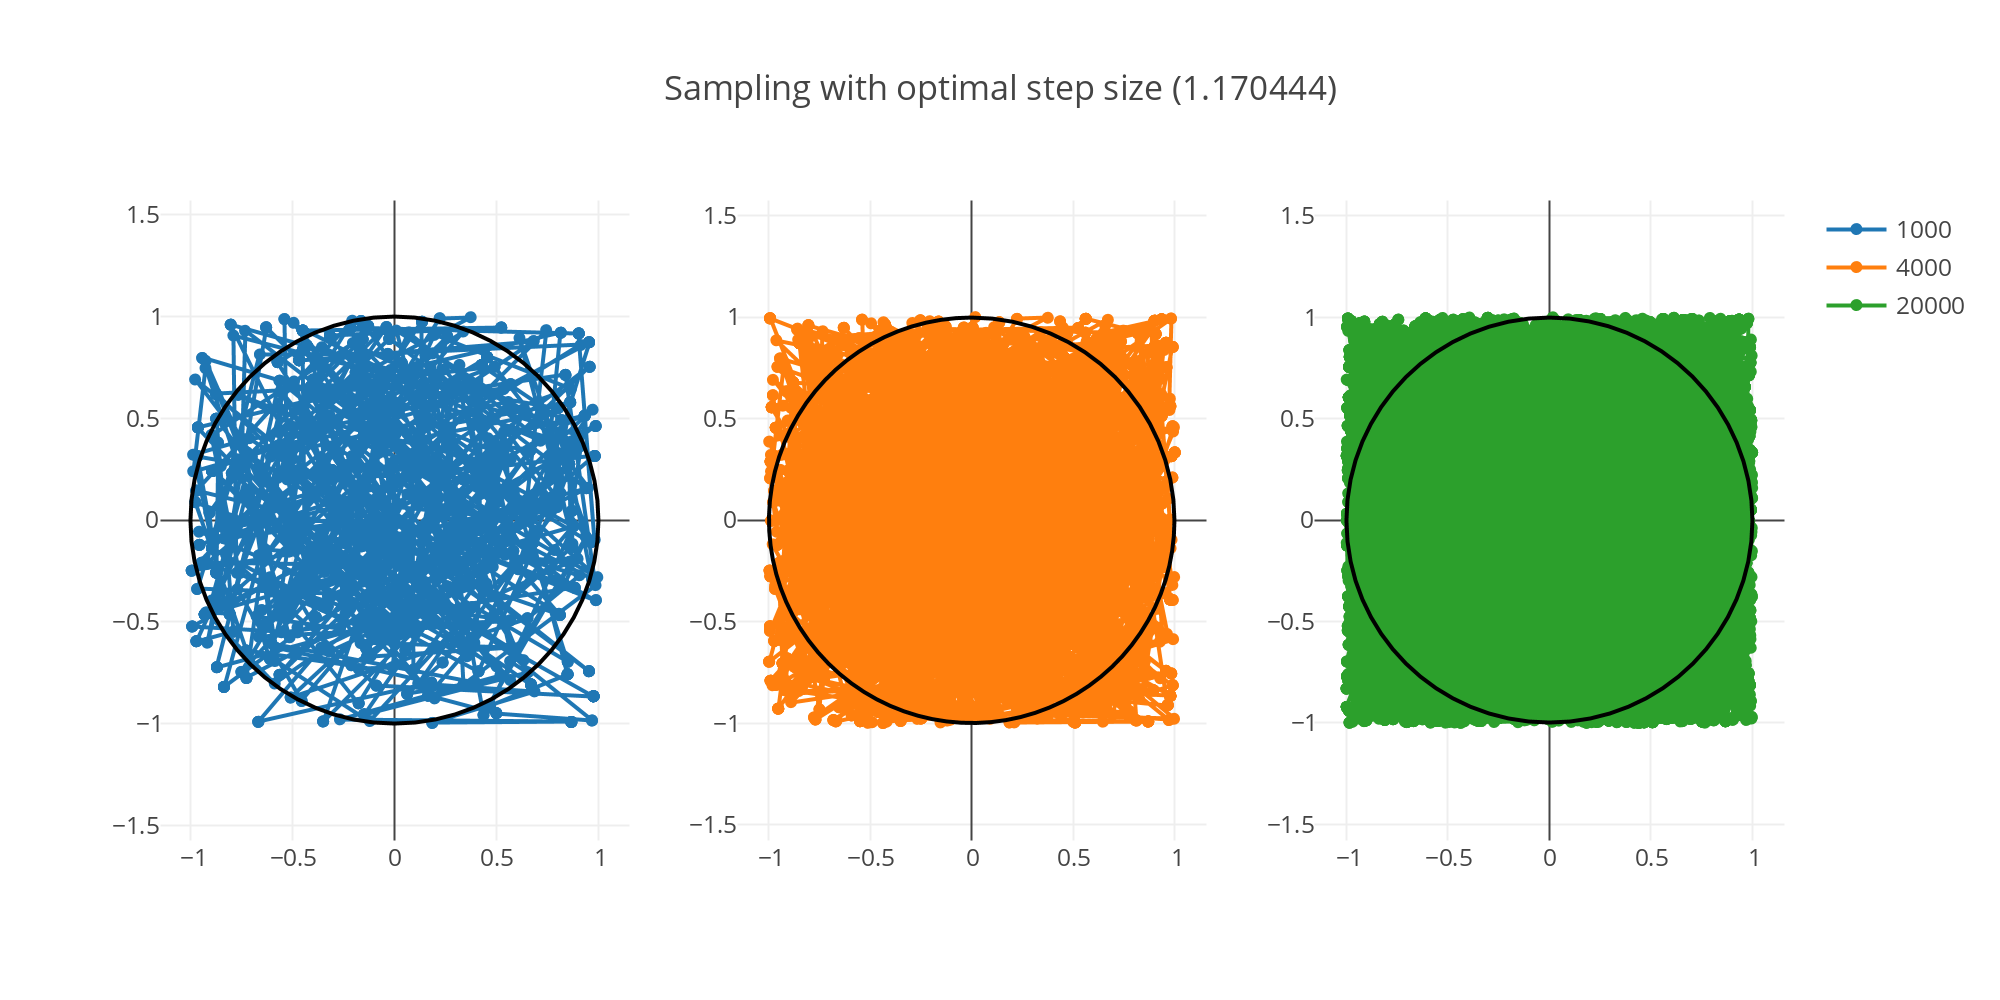

In [12]:
mc_opt = MarkovChain(20000, optimal_step_size)
mc_opt.run()
mc_opt.plot("Sampling with optimal step size ({:f})".format(optimal_step_size))

The result is quite satisfactory: even for short paths we get a quite uniform sampling (in the bulk). At the border we will have less points visualized since a lot of them are counted more than once (rejected moves). This is not surprising since we introduced the acceptance rule in order to fix this problem.


## Estimating π

In [51]:
NUM_STEPS = 2**18

mc_pi = MarkovChain(NUM_STEPS, optimal_step_size)

def estimate_pi():
    """Wraps the estimation of π using the previously defined mc_pi."""
    global mc_pi
    mc_pi.reset()
    mc_pi.run()
    
    return mc_pi.pi_estimate()


with futures.ProcessPoolExecutor() as executor:
    fs = [executor.submit(estimate_pi) for _ in range(100)]

estimates = np.array([f.result() for f in fs])


print("Mean value for π: {:f}".format(np.mean(estimates)))
print("Empirical variance: {:f}".format(np.sqrt(np.var(estimates))))
print("Variance of direct uniform sampling:",
      np.sqrt(np.pi * (4 - np.pi) / NUM_STEPS))

Mean value for π: 3.140963
Empirical variance: 0.006948
Variance of direct uniform sampling: 0.00320738939011


The empirical variance is bigger than the one predicted by the formula for independent random variables. This is due to the fact that the si are not independent. Each one depend directly on the previous (from the very definition of Markov chain). Therefore, $s_i$ and $s_j$ will be almost uncorrelated only if $|i-j|$ is big.
In order to estimate the typical error we must rely on other methods, such as the batching method.
The target of this method is to obtain random variables which are weakly dependent.This happens when the plateau arise in the plot. Indeed for independent RV this procedure should leave the variance unaltered (it's easy to check that, since it would be simply the sum of the variance of $N/2$ i.i.d random variables). On the other hand when the number of iterations increases we are computing an empirical variance on a small sample so the result is not reliable. During the initial iterations the $s_i$ that are close in the chain  will likely assume the same value so we cannot blindly apply the rule for independent RVs. In fact, in that case the empirical variance will be more or less the same of the previous iteration but since we divide for a smaller number our error estimate increases.
For this reason we can make a good estimate only in the central region (i.e. on the plateau).  
N.B the batching function can be used for whatever lenght of the sample. Ayway, We have chosen a number of steps equal to a power of two only to maximize the number of steps that can be done (i.e. graph of the variance with more points and so more precision) and actually making the process on all the spins

In [53]:
def batching(samples, variance):
    """Apply batching recursively to estimate the variance."""
    if len(samples) <= 1:
        return variance

    if len(samples) % 2 != 0:
        samples = np.append(samples, samples[-1])

    pairs = samples.reshape(len(samples) // 2, 2)

    samples = np.mean(pairs, axis=1)
    variance = np.append(variance, np.var(samples) / len(samples))

    return batching(samples, variance)


mc_pi.reset()
mc_pi.run()
samples = mc_pi.samples()

variance = batching(samples, np.array([]))


py.iplot([Scatter(y=variance, mode="lines+markers")])

In the following we implement a function that try to guess the plateau value automatically. Notice that we have anyway to check on the graph if this plateau does really exist. Of course we cand do all the job manually.

In [54]:
def plateau(variance):
    """Try to guess the plateau value automatically."""
    err = 1
    index = 0

    for i in range(len(variance) - 1):
        if abs(variance[i + 1] - variance[i]) <= err:
            err = abs(variance[i + 1] - variance[i])
            index = i + 1
    return (variance[index] + variance[index - 1])/2


print("Empirical variance: {:f}".format(np.sqrt(np.var(estimates))))
print("Variance of direct uniform sampling:",
      np.sqrt(np.pi * (4 - np.pi) / NUM_STEPS))
print("Variance estimate through batching:", np.sqrt(plateau(variance)))

Empirical variance: 0.006948
Variance of direct uniform sampling: 0.00320738939011
Variance estimate through batching: 0.00654299667989
